# Prepare Env

In [14]:
# Library

import platform
import sys
import os

import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.amp import autocast, GradScaler
import torchvision
from glob import glob
import cv2
import warnings

from scipy.signal import argrelmax

from scipy.stats import multivariate_normal

from PIL import Image

from tqdm import tqdm

# import albumentations as A
from sklearn.model_selection import train_test_split
# import segmentation_models_pytorch as smp

In [22]:
# Find session type
def find_session_type():
    # windows
    if os.name == 'nt':
        path = '../input/data/'

        import japanize_matplotlib
        sns.set(font="IPAexGothic")

    elif platform.system()  == 'Darwin':
        # Mac
        path = '../input/data/'
        return 'mac'

    elif os.name == 'posix':
    # Kaggle
        if 'KAGGLE_DATA_PROXY_TOKEN' in os.environ.keys():
            print('This is kaggle session')
            return 'kaggle'

    # Google Colab
        else:
            print('This is colab session')
            # セッションの残り時間の確認
            !cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 / 60 / 60 "h)"}'
            return 'colab'
    # Mac
    # elif 'MAC' in os.environ.keys():
    #     print('This is mac session')
    #     return 'mac'
# Example usage:
if find_session_type() == 'kaggle':
    print("Running in a Kaggle notebook")
elif find_session_type() == 'mac':
    print("Running on a Mac")
    path = '../input/data/'

elif find_session_type() == 'colab':
    from google.colab import drive
    print("Running in Google Colab")
    drive.mount('/content/drive')
    os.makedirs('/content/logs', exist_ok=True)
    os.makedirs('/content/kaggle/input', exist_ok=True)
    os.makedirs('/content/kaggle/output', exist_ok=True)
else:
    print("Not running in a Kaggle notebook or Google Colab")

# if is_google_colab():
#   byu_locating_bacterial_flagellar_motors_2025_path = kagglehub.competition_download('byu-locating-bacterial-flagellar-motors-2025')

#   print('Data source import complete.')

class Config:
    def __init__(self):
        self.seed = 42
        self.debug = False
        self.epochs = 10
        self.num_classes = 86
        self.ramdom_seed = 42
        self.batch_size = 4
        self.no_motor_use = 10

        self.train_size = 0.8

        self.root_dir = ''
        if find_session_type() == 'kaggle':
            self.root_dir = '/kaggle/'
        elif find_session_type() == 'colab':
            self.root_dir = '/content/kaggle/'
        elif find_session_type() == 'mac':
            self.root_dir = '../'
        self.working_dir = os.path.join(self.root_dir, 'working')
        self.pred_dir = os.path.join(self.root_dir, 'input', 'byu-locating-bacterial-flagellar-motors-2025', 'test')
        self.data_dir = os.path.join(self.root_dir, 'input', 'byu-locating-bacterial-flagellar-motors-2025')
        self.output_dir = os.path.join(self.root_dir, 'output')
        self.dataset_dir = os.path.join(self.working_dir, 'dataset')
        self.train_image_dir = os.path.join(self.dataset_dir, 'images','train')
        self.train_label_dir = os.path.join(self.dataset_dir, 'labels','train')
        self.val_image_dir = os.path.join(self.dataset_dir, 'images','val')
        self.val_label_dir = os.path.join(self.dataset_dir, 'labels','val')
        self.pred_dataset_dir = os.path.join(self.dataset_dir, 'test')

        os.makedirs(self.dataset_dir, exist_ok=True)
        os.makedirs(self.train_image_dir, exist_ok=True)
        os.makedirs(self.train_label_dir, exist_ok=True)
        os.makedirs(self.val_image_dir, exist_ok=True)
        os.makedirs(self.val_label_dir, exist_ok=True)

        assert os.path.exists(self.data_dir), f"Data directory {self.data_dir} does not exist."

        # 1st stage
        self.low_resol_setting = {
            "voxel_size": 16,
            "image_path": os.path.join(self.working_dir, 'low_resol', 'images'),
            "label_path": os.path.join(self.working_dir, 'low_resol', 'labels'),
            "model_fol": os.path.join(self.output_dir, 'low_resol', 'model'),
            "cov_val" : 5e-4,
            "sharpness": 0.5,
            "threshold": 0.6
        }

        # 2nd stage
        self.high_resol_setting = {
            "voxel_size": 64,
            "translate": 0.2,
            "image_path": os.path.join(self.working_dir, 'high_resol'),
            "label_path": os.path.join(self.working_dir, 'high_resol', 'labels'),
            "model_fol": os.path.join(self.output_dir, 'high_resol', 'model'),
            "cov_val" : 1e-4,
            "crop_thresh": 0.5,
            "sharpness": 0.5,
            "threshold": 0.8
            # positive: negative= 1:1,
        }
        os.makedirs(self.low_resol_setting['image_path'], exist_ok=True)
        os.makedirs(self.low_resol_setting['label_path'], exist_ok=True)
        os.makedirs(self.low_resol_setting['model_fol'], exist_ok=True)
        os.makedirs(self.high_resol_setting['image_path'], exist_ok=True)
        os.makedirs(self.high_resol_setting['label_path'], exist_ok=True)
        os.makedirs(self.high_resol_setting['model_fol'], exist_ok=True)
        # Torch settings
        self.lr = 1e-4
        self.grad_norm = 0.1
        self.init_scale = 4096

        random.seed(self.ramdom_seed)
        np.random.seed(self.ramdom_seed)
        torch.manual_seed(self.ramdom_seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(self.ramdom_seed)
            torch.backends.cudnn.deterministic = True

class GPUProfiler:
    def __init__(self, name):
        self.name = name
        self.start_time = None

    def __enter__(self):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        self.start_time = time.time()
        return self

    def __exit__(self, *args):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        elapsed = time.time() - self.start_time
        # print(f"[PROFILE] {self.name}: {elapsed:.3f}s")

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
if device.startswith('cuda'):
    # Set CUDA optimization flags
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 on Ampere GPUs
    torch.backends.cudnn.allow_tf32 = True

    # Print GPU info
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
    print(f"Using GPU: {gpu_name} with {gpu_mem:.2f} GB memory")

    # Get available GPU memory and set batch size accordingly
    free_mem = gpu_mem - torch.cuda.memory_allocated(0) / 1e9
    BATCH_SIZE = max(8, min(32, int(free_mem * 4)))  # 4 images per GB as rough estimate
    print(f"Dynamic batch size set to {BATCH_SIZE} based on {free_mem:.2f}GB free memory")
else:
    print("GPU not available, using CPU")
    BATCH_SIZE = 4  # Reduce batch size for CPU

config = Config()

config.batch_size = BATCH_SIZE

Running on a Mac
GPU not available, using CPU


In [ ]:
if find_session_type() == 'kaggle':
    config.data_dir = '/kaggle/input/byu-locating-bacterial-flagellar-motors-2025'
    config.output_dir = '/kaggle/output'
    config.dataset_dir = '/kaggle/working/dataset'
elif find_session_type() == 'colab':
    config.data_dir = '/content/kaggle/input/byu-locating-bacterial-flagellar-motors-2025'
    config.output_dir = '/content/kaggle/output'
    config.dataset_dir = os.path.join(config.working_dir, 'dataset')
    os.makedirs(config.dataset_dir, exist_ok=True)
    datapath = '/content/drive/MyDrive/kaggle/BYU-motor-detection/datas/3d-low-resol'
    !unzip -q {datapath} -d {config.dataset_dir}

This is colab session
0.00907975days (0.217914h)
This is colab session
0.0090809days (0.217942h)


# Helper Setup

3D-CNNに読み込ませる


In [ ]:
# Model developing

# 3D U-net by pytorch

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_ch, mdl_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, padding="same"),
            nn.BatchNorm3d(mdl_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(mdl_ch, out_ch, kernel_size=3, padding="same"),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
class UpConv_3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="trilinear", align_corners=True)
        self.bn1 = nn.BatchNorm3d(in_channels)
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 2, padding="same")
        self.bn2 = nn.BatchNorm3d(out_channels)

    def forward(self, x):
        x = self.up(x)
        x = self.bn1(x)
        x = self.conv(x)
        x = self.bn2(x)
        return x

class UNet3D(nn.Module):
    def __init__(self, mode):
        super().__init__()
        if mode == 'low':
            self.enc1 = DoubleConv(1, 8, 8)
            self.enc2 = DoubleConv(8, 32, 32)
            self.enc3 = DoubleConv(32, 128, 128)
            self.enc4 = DoubleConv(128, 512, 512)

            self.bottleneck = DoubleConv(512, 1024, 1024)

            self.up4 = UpConv_3D(1024, 512)
            self.dec4 = DoubleConv(1024, 512, 512)
            self.up3 = UpConv_3D(512, 128)
            self.dec3 = DoubleConv(256, 128, 128)
            self.up2 = UpConv_3D(128, 32)
            self.dec2 = DoubleConv(64, 32, 32)
            self.up1 = UpConv_3D(32, 8)
            self.dec1 = DoubleConv(16, 8, 8)

            self.conv1 = nn.Conv3d(8, 1, kernel_size=1)

            self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        if mode == 'high':
            self.enc1 = DoubleConv(1, 16, 16)
            self.enc2 = DoubleConv(16, 64, 64)
            self.enc3 = DoubleConv(64, 128, 128)
            self.enc4 = DoubleConv(128, 256, 256)
            self.enc5 = DoubleConv(256, 512, 512)

            self.bottleneck = DoubleConv(512, 1024, 1024)

            self.up5 = UpConv_3D(1024, 512)
            self.dec5 = DoubleConv(1024, 512, 512)
            self.up4 = UpConv_3D(512, 256)
            self.dec4 = DoubleConv(512, 256, 256)
            self.up3 = UpConv_3D(256, 128)
            self.dec3 = DoubleConv(256, 128, 128)
            self.up2 = UpConv_3D(128, 64)
            self.dec2 = DoubleConv(128, 64, 64)
            self.up1 = UpConv_3D(64, 16)
            self.dec1 = DoubleConv(32, 16, 16)

            self.conv1 = nn.Conv3d(16, 1, kernel_size=1)

            self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.enc1(x)
        x1 = x
        x = self.pool(x)

        x = self.enc2(x)
        x2 = x
        x = self.pool(x)

        x = self.enc3(x)
        x3 = x
        x = self.pool(x)

        x = self.enc4(x)
        x4 = x
        x = self.pool(x)

        x = self.bottleneck(x)

        x = self.up4(x)
        x = torch.cat((x, x4), dim=1)
        x = self.dec4(x)

        x = self.up3(x)
        x = torch.cat((x, x3), dim=1)
        x = self.dec3(x)

        x = self.up2(x)
        x = torch.cat((x, x2), dim=1)
        x = self.dec2(x)

        x = self.up1(x)
        x = torch.cat((x, x1), dim=1)
        x = self.dec1(x)

        x = self.conv1(x)
        return x

def check_dataset_consistency(dataset_or_loader, num_samples=5, visualize=True):
    """
    3D-UNet用データセットまたはデータローダーのバリデーションを行う関数。

    Args:
        dataset_or_loader: PyTorch DatasetまたはDataLoaderインスタンス
        num_samples: チェックするサンプル数
        visualize: Trueなら入力・ラベルを可視化する
    """
    print("\n=== Dataset Consistency Check Start ===\n")

    if hasattr(dataset_or_loader, 'dataset'):
        # DataLoaderの場合
        dataset = dataset_or_loader.dataset
        loader = dataset_or_loader
        use_loader = True
    else:
        # Datasetの場合
        dataset = dataset_or_loader
        use_loader = False

    if use_loader:
        data_iter = iter(loader)
    else:
        indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    for i in range(num_samples):
        if use_loader:
            batch = next(data_iter)
            X, Y = batch
            X, Y = X[0], Y[0]  # バッチの最初のサンプルを使用
        else:
            idx = indices[i]
            X, Y = dataset[idx]

        # --- 1. 形状チェック ---
        assert X.ndim == 4, f"Input X should have 4 dimensions (C,D,H,W), got {X.shape}"
        assert Y.ndim == 3 or Y.ndim == 4, f"Label Y should have 3 or 4 dimensions, got {Y.shape}"

        # --- 2. チャンネル数確認 ---
        C, D, H, W = X.shape
        assert C in [1, 3], f"Unexpected channel count {C}"

        # --- 3. 値の範囲確認 ---
        if torch.is_tensor(X):
            X_min, X_max = X.min().item(), X.max().item()
        else:
            X_min, X_max = np.min(X), np.max(X)

        print(f"Sample {i}: Input value range = ({X_min:.3f}, {X_max:.3f})")
        assert not np.isnan(X_min) and not np.isnan(X_max), "NaN detected in input"

        # --- 4. 型確認 ---
        assert isinstance(X, (torch.Tensor, np.ndarray)), "Input X must be Tensor or ndarray"
        assert isinstance(Y, (torch.Tensor, np.ndarray)), "Label Y must be Tensor or ndarray"

        # --- 5. 欠損値チェック ---
        if torch.isnan(X).any() or torch.isnan(Y).any():
            raise ValueError(f"NaN found in sample {i}")

        # --- 6. 入力とラベルの対応確認 ---
        if Y.ndim == 4:
            assert Y.shape[1:] == X.shape[1:], f"Mismatch between input and label shape: {X.shape} vs {Y.shape}"
        else:
            assert Y.shape == X.shape[1:], f"Mismatch between input and label shape: {X.shape} vs {Y.shape}"

        # --- 7. 簡易可視化 ---
        if visualize:
            slice_idx = D // 2
            fig, axs = plt.subplots(1, 2, figsize=(8, 4))

            axs[0].imshow(X[0, slice_idx].cpu().numpy(), cmap='gray')
            axs[0].set_title('Input (Mid slice)')

            if Y.ndim == 4:
                axs[1].imshow(Y[0, slice_idx].cpu().numpy(), cmap='gray')
            else:
                axs[1].imshow(Y[slice_idx].cpu().numpy(), cmap='gray')
            axs[1].set_title('Label (Mid slice)')

            plt.show()

    print("\n=== Dataset Consistency Check Completed ===\n")
# Check the model network
model = UNet3D(mode='low').to(device)
print(model)

# Loss function
def criterion(pred, target):
    """
    Custom loss function for 3D U-Net model.
    Args:
        pred (torch.Tensor): Predicted output from the model.
        target (torch.Tensor): Ground truth labels.
    Returns:
        torch.Tensor: Computed loss value.
    """
    loss_fn = nn.SmoothL1Loss(reduction='mean')
    # Calculate the loss using the defined loss function
    loss = loss_fn(pred, target)
    return loss

def three_d_nms(pb_tensor:np.ndarray, threshold=0.5, kernel_size=3):

    """
    Apply 3D Non-Maximum Suppression (NMS) to the input tensor.
    Args:
        pb_tensor (np.ndarray): Posibility Distrubution Function map
    """

    assert pb_tensor.ndim == 3, f"Input tensor must have 4 dimensions (D, H, W)"
    return pb_tensor
    
def predict_on_samples(model:torch.nn.Module, dataloader:DataLoader, settings:dict, num_samples=5):

    """
    Predict on a few samples from the dataloader and visualize the results.
    Args:
        model (torch.nn.Module): The trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
        num_samples (int): Number of samples to visualize.
        thresh (float): Threshold for binarizing the predictions.
    """
    model.eval()
    fig, axs = plt.subplots(3, num_samples, figsize=(12, 4))
    with torch.no_grad():
        for i, (X, Y) in tqdm(enumerate(dataloader)):
            if i >= num_samples:
                break
            X = X.to(device)
            Y = Y.to(device)

            pred = model(X)
            pred = torch.sigmoid(pred)
            pred = pred.to(device).numpy()

            pos = (pred > settings['threshold']) * pred

            # Visualize the first sample
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            slice_idx = X.shape[2] // 2

            axs[i,0].imshow(X[0, 0, slice_idx].cpu().numpy(), cmap='gray')
            axs[i,0].set_title('Input')

            axs[i,1].imshow(Y[0, slice_idx].cpu().numpy(), cmap='hot')
            axs[i,1].set_title('Ground Truth')

            axs[i,2].imshow(pred[0, 0, slice_idx].cpu().numpy(), cmap='hot')
            axs[i,2].set_title('Prediction')

        fig.show()

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = glob(os.path.join(image_dir, '*.npy'))
        self.label_files = glob(os.path.join(label_dir, '*.npy'))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        label_path = self.label_files[idx]

        try:
            image_np = np.load(image_path, mmap_mode='r').copy()
            label_np = np.load(label_path, mmap_mode='r').copy()

            image_tensor = torch.from_numpy(image_np).float()
            label_tensor = torch.from_numpy(label_np).float()

            if image_tensor.ndim == 3:
                image_tensor = image_tensor.unsqueeze(0)

            if self.transform:
                image_tensor = self.transform(image_tensor)

            return image_tensor, label_tensor

        except Exception as e:
            warnings.warn(f"読み込み失敗: {image_path}, {label_path}\nエラー内容: {e}")

            # ダミーデータを返す（学習を止めずに続ける）
            dummy_image = torch.zeros((1, 32, 32, 32), dtype=torch.float32)  # 例
            dummy_label = torch.zeros((32, 32, 32), dtype=torch.float32)  # 例

            return dummy_image, dummy_label

def simple_3d_nms(pred, threshold=0.5, kernel_size=3):
    """
    Simple 3D Non-Maximum Suppression (NMS) function.
    Args:
        pred (torch.Tensor): Input tensor of shape (C, D, H, W).
        threshold (float): Threshold for NMS.
        kernel_size (int): Size of the kernel for NMS.
    Returns:
        torch.Tensor: Output tensor after applying NMS.
    """

    if pred.ndim == 4:
        pred = pred.squeeze(0)
    if pred.ndim != 4:
        raise ValueError("Input tensor must have 4 dimensions (C, D, H, W)")
    pred = F.threshold(pred, threshold, 0)
    pooled = F.max_pool3d(pred.unsqueeze(0).unsqueeze(0),
                          kernel_size=kernel_size, stride=1,
                          padding=kernel_size//2)

    peaks = (pred == pooled) & (pooled > threshold)
    peak_coords = torch.nonzero(peaks, as_tuple=False)
    return peak_coords.cpu().numpy()

def calculate_metrics(pred, target, threshold=0.5):
    """
    Calculate precision, recall, and F1 score for the predicted and target tensors.
    Args:
        pred (torch.Tensor): Predicted tensor.
        target (torch.Tensor): Target tensor.
        threshold (float): Threshold for binarizing the predictions.
    Returns:
        tuple: Precision, recall, and F1 score.
    """
    pred = pred.float()
    target = target.float()

    mse = F.mse_loss(pred, target, reduction='mean').item()
    mae = F.l1_loss(pred, target, reduction='mean').item()

    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()

    # Dice the metrics
    intersection = torch.sum(pred_binary * target_binary)
    union = torch.sum(pred_binary + target_binary)

    if union == 0:
        dice = 1.0
    else:
        dice = (2 * intersection / union).item()

    iou = (intersection / (torch.sum(pred_binary) + torch.sum(target_binary) - intersection+1e-7)).item()

    return {
        'mse': round(mse, 5),
        'mae': round(mae, 5),
        'dice': round(dice, 5),
        'iou' : round(iou, 5)
    }

def find_motor_pos(voxel:np.ndarray, voxel_origin:tuple):
    """
    Find the position of the motor in the voxel.
    Args:
        voxel (np.ndarray): The input voxel.
        voxel_ab_size (tuple): The size of the voxel.
        voxel_origin (tuple): The origin of the voxel.
    Returns:
        tuple: The position of the motor in the voxel.
    """
    # Calculate the center of the motor
    relative_pos = np.unravel_index(np.argmax(voxel), voxel.shape)

    absolute_pos = np.array(relative_pos) + np.array(voxel_origin)
    
    return absolute_pos

UNet3D(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(8, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (double_conv): Sequential(
      (0): C

In [21]:
pred = np.array([
        [1, 4, 0, 9, 0, 3, 2],
        [4, 0, 0, 1, 2, 3, 7],
        [2, 9, 2, 0, 9, 0, 7],
        [0, 0, 7, 9, 6, 3, 1],
        [0, 4, 4, 7, 2, 8, 3]
    ])
pred = np.array(pred)
pred_pos = argrelmax(pred, order=3, mode='wrap')
print(pred_pos)

(array([1, 2, 2, 3, 4]), array([0, 1, 4, 2, 5]))


In [5]:
def test_metrics():
    """
    Test the calculate_metrics function with dummy data.
    """
    pred = torch.tensor([[[[0.1, 0.2], [0.3, 0.4]]]])
    target = torch.tensor([[[[0.1, 0.1], [0.3, 1.0]]]])

    metrics = calculate_metrics(pred, target, threshold=0.01)
    print("Metrics:", metrics)

if __name__ == "__main__":
    test_metrics()

Metrics: {'mse': 0.0925, 'mae': 0.175, 'dice': 1.0, 'iou': 1.0}


### Train Section

Train dataset size: 297

=== Dataset Consistency Check Start ===

Sample 0: Input value range = (34.312, 247.531)


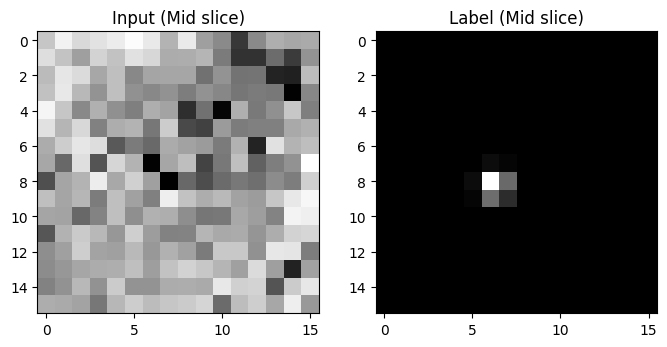


=== Dataset Consistency Check Completed ===



  0%|          | 0/10 [01:58<?, ?it/s]


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray._reconstruct was not an allowed global by default. Please use `torch.serialization.add_safe_globals([_reconstruct])` or the `torch.serialization.safe_globals([_reconstruct])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
history = {
    'train_loss': [],
    'val_loss': []
}
best_val_loss = float('inf')
best_model_path = os.path.join(config.output_dir, 'best_model.pth')
config.train_image_dir = os.path.join(config.dataset_dir, 'low_resol', 'images','train')
config.train_label_dir = os.path.join(config.dataset_dir, 'low_resol', 'labels','train')
config.val_image_dir = os.path.join(config.dataset_dir, 'low_resol', 'images','val')
config.val_label_dir = os.path.join(config.dataset_dir, 'low_resol', 'labels','val')

assert os.path.exists(config.train_image_dir), f"Train image directory not found: {config.train_image_dir}"
assert os.path.exists(config.train_label_dir), f"Train label directory not found: {config.train_label_dir}"
# Low resolution
model = UNet3D(mode='low').to(device)
setting = config.low_resol_setting
optimizer = optim.Adam(model.parameters(), lr=config.lr)

train_dataset = CustomDataset(config.train_image_dir, config.train_label_dir)
val_dataset = CustomDataset(config.val_image_dir, config.val_label_dir)

print(f"Train dataset size: {len(train_dataset)}")

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    num_workers=4,
    pin_memory=True,
    shuffle=True)
val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    num_workers=4,
    pin_memory=True,
    shuffle=False)

# Validation
check_dataset_consistency(train_loader, num_samples=1, visualize=True)

scaler = GradScaler(init_scale=config.init_scale)

for epoch in tqdm(range(config.epochs)):
    train_loss = 0.0
    val_loss = 0.0
    all_preds = []
    all_targets = []

    for x, y in train_loader:
        optimizer.zero_grad()

        with autocast(device, dtype=torch.float16):
            y = model(x)
            loss = criterion(x, y)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)

        nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        history['train_loss'].append(loss.item())
        if config.debug:
            break

    #Validation loop
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for val_x, val_y in val_loader:
            x_val = x_val.to(device).float() # Tensor
            y_val = y_val.to(device).float() # Tensor

            with autocast(device_type=device.type, dtype=torch.float16):
                output = model(x_val)
                loss = criterion(output, y_val)

            val_loss += loss.item()
            
            # 予測と正解を蓄積
            preds = output.sigmoid()  # 2値分類ならsigmoid
            preds = (preds > setting['threshold']).float()
            all_preds.append(preds.cpu())
            all_targets.append(y_val.cpu())
    
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{config.epochs}] Train Loss: {train_loss:.4f} Val Loss: {avg_val_loss:.4f}")

predict_on_samples(model, val_loader, num_samples=5)